# Ejercicio N°4.4
Winsconsin Breast Cancer dataset. Contiene una tabla con 569 datos de histología mamaria humana, 357 casos de tejido tumoral benigno y 212 tejido maligno. Los datos son 32 atributos radiómicos (tamaños, formas, texturas, etc.). El objetivo es desarrollar un clasificador que a través de los atributos permita predecir la benignidad o malignidad de un tumor.
https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/ProjectBCD

vers01: en la función search_modelo_y_grid_metricas() se setea GridSearchCV(), se ajusta y elige el modelo optimo y se extra grid_cv con las estadisticas f1, precision y recall en los datos de train y validación.

verso2: semuestra el modelo y validación en el main. El armado de las metricas esta metricasyplots()

In [1]:
# Librerias 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from io import StringIO
import time

In [2]:
# Funciones extras
# -----------------------------------------------------------------------------
def metricas(y,y_pred,ponderacion='weighted'):
  m_balanced_accuracy = metrics.balanced_accuracy_score(y,y_pred)
  m_f1 = metrics.f1_score(y,y_pred, average=ponderacion)
  m_precision = metrics.precision_score(y,y_pred, average=ponderacion,zero_division=1)
  m_recall = metrics.recall_score(y,y_pred, average=ponderacion,zero_division=0)
  return m_balanced_accuracy,m_f1,m_precision,m_recall

# ----------------------------------------------------------------------------    
def metricas_clasificadores_knn(dataset,ax,ponderacion = 'weighted'):
# dataset: es una lista [X_train, y_train, X_test,y_test] 
# de len 2 (datos de entrenamiento) o len 4 (entrenamiento y validación)    
# Se generan diferentes modelos de clasificadores (variando la cantidad de vecinos),
# y se guardan metricas para cada caso.

  len(dataset)
  if len(dataset)==2: 
      X_train = dataset[0]; y_train = dataset[1]
      X_test  = dataset[0]; y_test  = dataset[1]
      #print('len2 \n')
  elif len(dataset)==4:
      X_train = dataset[0]; y_train = dataset[1]
      X_test  = dataset[2]; y_test  = dataset[3]
      #print('len4 \n')
  else:
      print('Error en la longitud del dataset')
    
  # Seteo del clasificador
  kmax = 30   # maxima cantidad de k-vecinos a usar
  X_train = np.array(X_train);
  y_train = np.array(y_train)#.reshape(-1,1)

  kvecinos = np.zeros(kmax)
  m_balanced_accuracy = np.zeros(kmax)
  m_f1 = np.zeros(kmax)
  m_precision = np.zeros(kmax)
  m_recall = np.zeros(kmax)
  knn_score = np.zeros(kmax)

  # Ajuste de varios clasificadores para evaluar metricas
  for k in range(kmax):
    kvecinos[k] = k+1
    Myknn = KNeighborsClassifier(n_neighbors=k+1)       # se instancia el modelo
    Myknn.fit(X_train,y_train)                          # ajuste del modelo  
    y_pred = Myknn.predict(X_test)                      # predicciones sobre el test
    knn_score[k]=Myknn.score(X_test,y_test)
    m_balanced_accuracy[k],m_f1[k],m_precision[k],m_recall[k] = metricas(y_test,y_pred,ponderacion)

  # Preparación de metricas para ploteo
    df_score = pd.DataFrame({'k-vecinos':kvecinos,'balanced_accuracy': m_balanced_accuracy,
                            'f1 score':m_f1,'precision':m_precision,'recall':m_recall,'knn-score':knn_score})
  sns.lineplot(data=pd.melt(df_score, 'k-vecinos',var_name='Medidas'),x='k-vecinos', y='value', hue='Medidas',ax=ax )

# -----------------------------------------------------------------------------
def metricasyplots(grid_cv):
    # Extraccion individual de las metricas para su grafico
    #-------------------------------------------------------------------------------
    grid_cv1 = grid_cv.drop(['params']+[col for col in grid_cv.columns if 'rank' in col]+
                           [col for col in grid_cv.columns if 'mean' in col]+
                           [col for col in grid_cv.columns if 'std' in col],axis=1)
    grid_cv_long = grid_cv1.melt('param_n_neighbors',var_name='Medidas')

    #-------------------------------------------------------------------------------
    grid_cv_f1 = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('f1')]
    grid_cv_f1 = grid_cv_f1.replace('_f1_weighted','',regex=True)
    #-------------------------------------------------------------------------------
    grid_cv_precision = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('precision')]
    grid_cv_precision = grid_cv_precision.replace('_precision_weighted','',regex=True)
    #-------------------------------------------------------------------------------
    grid_cv_recall = grid_cv_long.loc[grid_cv_long['Medidas'].str.contains('recall')]
    grid_cv_recall = grid_cv_recall.replace('_recall_weighted','',regex=True)
    
    # plots f1_score, precision_score y recall_score
    fig,ax = plt.subplots(1,3,figsize=(12,6))
    ax=ax;
    sns.lineplot(grid_cv_f1,x='param_n_neighbors', y='value', hue='Medidas',ax=ax[0])
    ax[0].set_title('CV f1_score'); ax[0].set_ylim([0.8,1]);

    sns.lineplot(grid_cv_precision,x='param_n_neighbors', y='value', hue='Medidas',ax=ax[1])
    ax[1].set_title('CV precision_score'); ax[1].set_ylim([0.8,1]);

    sns.lineplot(grid_cv_recall,x='param_n_neighbors', y='value', hue='Medidas',ax=ax[2])
    ax[2].set_title('CV recall_score'); ax[2].set_ylim([0.8,1]);
    fig.suptitle('CV Metricas (promedio ponderado según la probabilidad de c/clase)');

    #% medias de todas las metricas
    #-------------------------------------------------------------------------------
    grid_cv_means = pd.concat([grid_cv.filter(like='neighbors'),
                                grid_cv.filter(like='mean').filter(like='weighted')],axis=1)
    grid_cv_means_long = grid_cv_means.melt('param_n_neighbors',var_name='Medidas')

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    ax=ax1; ax1.set_ylim([0.9,1]);
    mean_train = grid_cv_means_long[grid_cv_means_long['Medidas'].str.contains('train')]
    sns.lineplot(mean_train,x='param_n_neighbors', y='value', hue='Medidas',ax=ax)
    ax.set_title('data entrenamiento');

    ax=ax2; ax2.set_ylim([0.9,1]);
    mean_test = grid_cv_means_long[grid_cv_means_long['Medidas'].str.contains('test')]
    sns.lineplot(mean_test,x='param_n_neighbors', y='value', hue='Medidas',ax=ax)
    ax.set_title('data validación');
    fig.suptitle('CV Metricas (promedio de los splits)');


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

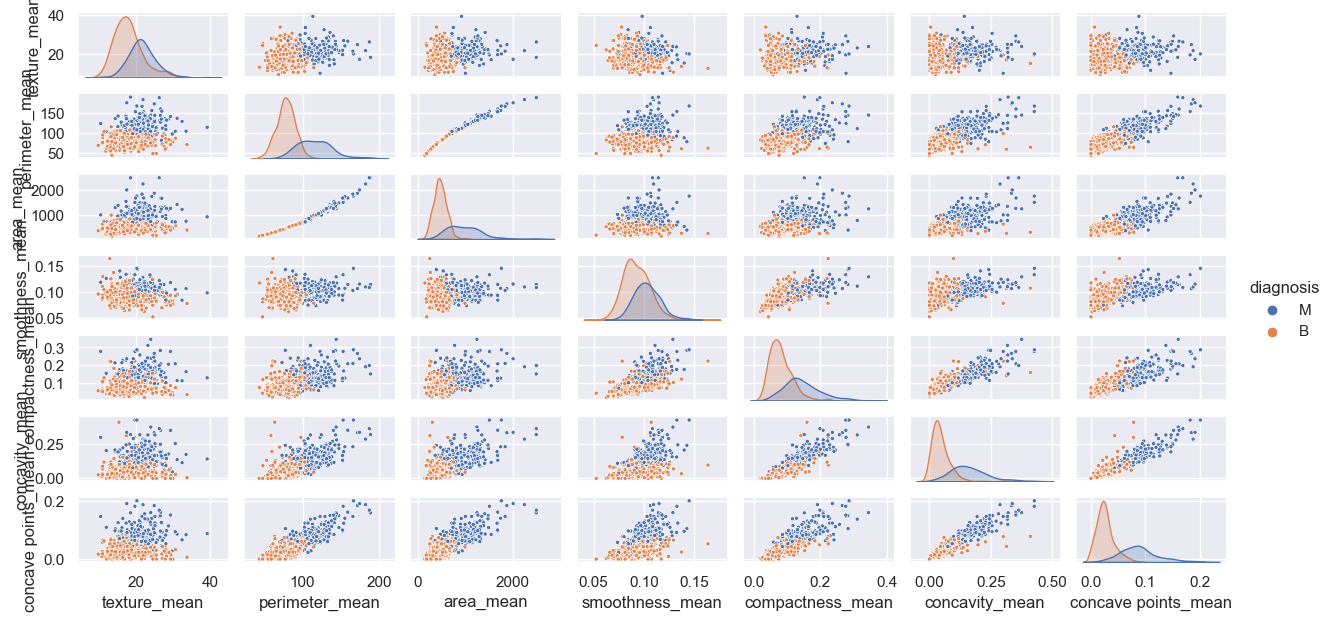

In [3]:
#%%
# Seteo de variables
# -----------------------------------------------------------------------------
url_file = 'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRBG/data/colors.csv'
url_file = 'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBCD/data/data.csv'
# 0. Carga de datos 
# -----------------------------------------------------------------------------
#Rainbow_Guru = pd.read_csv(url_file)
data_bcd = pd.read_csv(url_file)
#%
# 1. Exploración inicial
df = data_bcd.copy()
namecols = df.columns
df = df.drop(['id','Unnamed: 32'],axis=1)
print(df.info())

#%
# 2. Visualizacion de datos cols respecto al tiempo y
#df = data_bcd.copy()
sns.pairplot(df,vars=df.columns[2:9],markers='.',diag_kind='kde',hue='diagnosis',height=.9,aspect=2)
#sns.pairplot(df,vars=df.columns[9:19],markers='.',diag_kind='kde',height=.9,aspect=2)
#sns.countplot(x='diagnosis', data=df)

#%
# se convierten datos categoricos 
#df_cat = df.iloc[:,0:3].apply(lambda x: pd.factorize(x)[0])
#df = pd.concat([df.drop(df.columns[0:3],axis=1),df_cat],axis=1, join='inner')
(y_int,y_label) = pd.factorize(df['diagnosis'])
df['diagnosis'] = y_int



Son 398 datos para entrenamiento y 171 datos para prueba


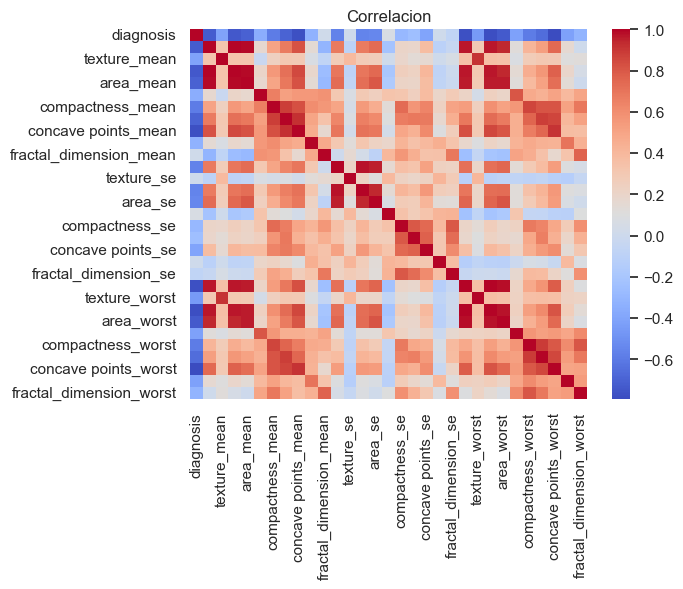

In [4]:
# -----------------------------------------------------------------------------
# 3. Analisis de correlación
# C2. Análisis de outliers (curacion)
corr_matrix = df.corr()
#print(corr_matrix)

fig,ax=plt.subplots();
sns.heatmap(corr_matrix,cmap='coolwarm',ax=ax)#'RdPu')
ax.set_title('Correlacion');

# Preparacion de los datos
# -----------------------------------------------------------------------------
#df = data_int.copy()
prop_test_size = 0.3
target = 'diagnosis'
X = df.drop(target,axis=1); X = np.array(X);
y = df[target]; y = np.array(y);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=prop_test_size)
print('Son {} datos para entrenamiento y {} datos para prueba'.
      format(X_train.shape[0], X_test.shape[0]))

## KNN - Estrategia01
Mediante la función **metricas_clasificadores_knn()** se,
- instancian 30 modelos knn,
- se ajustan y calculan las métricas f1, precision y recall

Se grafican los resultados obtenidos para
- dataset completo
- daset dividido

Para el Dataset dividido, las metricas se calculan sobre los datos de test


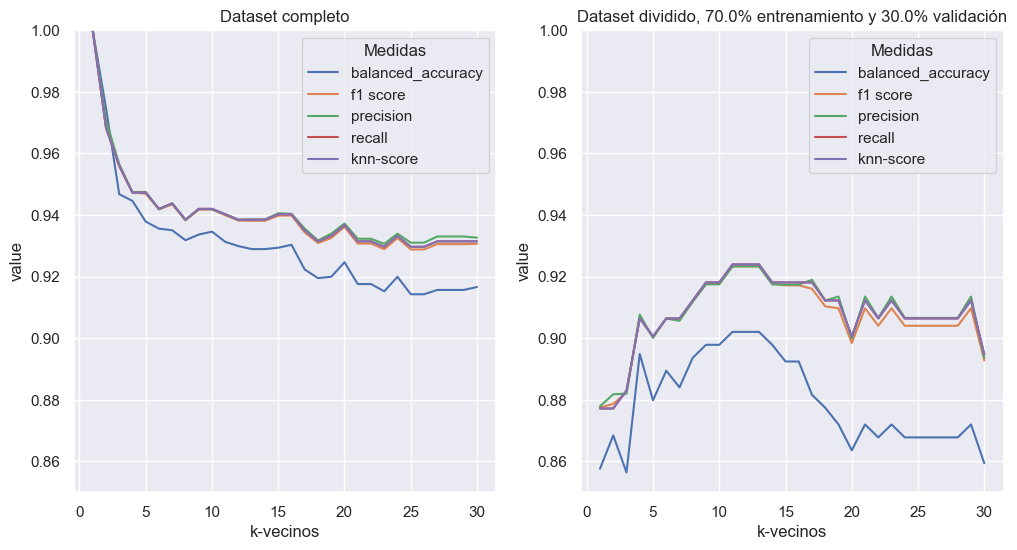

In [5]:
#%%
# Entrenamiento y validación con el data completo
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax=ax1; ax.set_ylim([.85,1]);
metricas_clasificadores_knn([X,y],ax); ax.set_title('Dataset completo');ax.grid(True)

# Entrenamiento y validación divididos
dataset =  [X_train, y_train, X_test,y_test]
ax=ax2; ax.set_ylim([.85,1]);
metricas_clasificadores_knn(dataset,ax);
ax.set_title('Dataset dividido, {}% entrenamiento y {}% validación'.
                format(100*(1-prop_test_size),100*prop_test_size)); 
print('Para el Dataset dividido, las metricas se calculan sobre los datos de test')

## KNN - Estrategia02
Similar a la estrategia anterior, esta estrategia emplea las funciones **GridSearchCV()** y **metricasyplots()** para
- instanciar 30 modelos knn,
- ajustar sobre los data de entrenamiento y calcular las métricas f1, precision y recall sobre los data de validación

Se grafican 
- para cada uno de los split el promedio ponderado según la probabilidad de c/clase de las metricas obtenidas
- promedio entre todos los splis de las metricas obtenidas


Mejor elección de cantidad de vecinos es:  7
Score alcanzado(f1): 94.18%


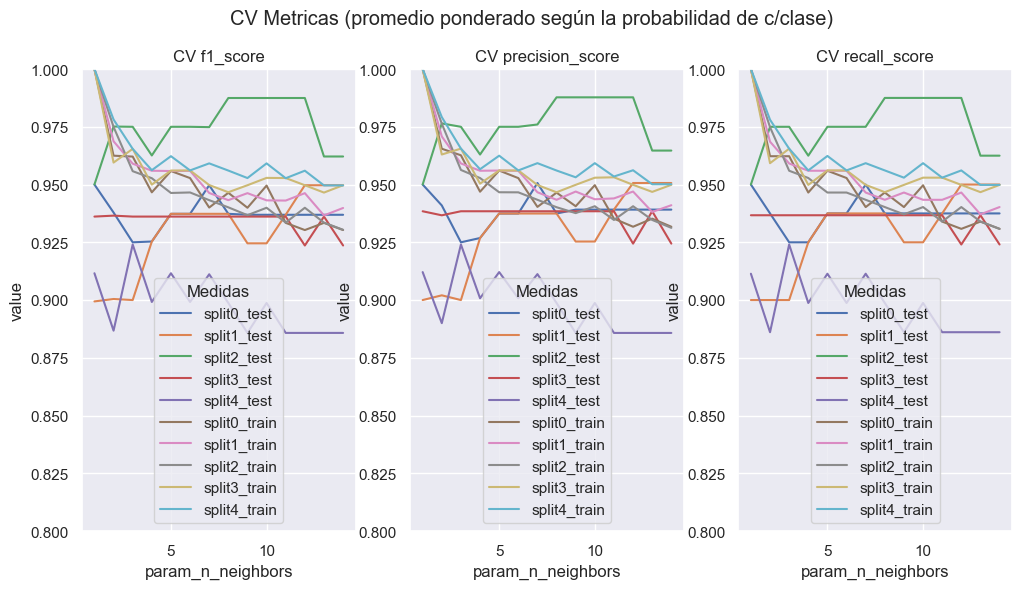

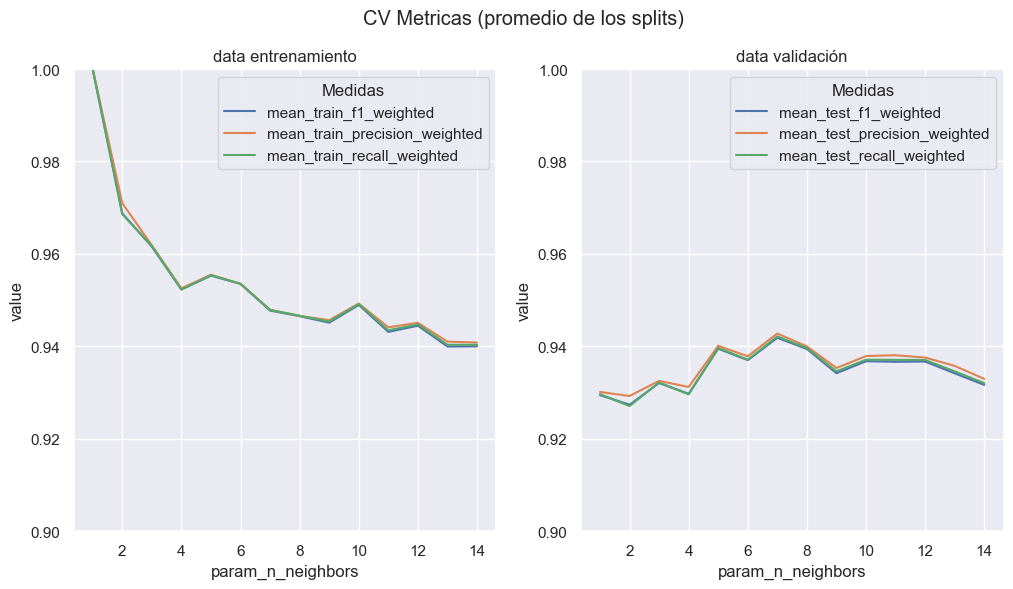

In [6]:
#%% 
# Seteo del modelo - KNN
# ----------------------------------------------------------------------------
knn = KNeighborsClassifier()
k_range = list(range(1, 15))
param_grid = dict(n_neighbors=k_range)
# Validación cruzada
n_splits = 5
# ----------------------------------------------------------------------------
grid = GridSearchCV(
                    knn, param_grid,cv=n_splits,
                    scoring=['f1_weighted', 'precision_weighted', 'recall_weighted'],
                    refit='f1_weighted', return_train_score=True, verbose=0)

# Ajuste
grid.fit(X_train, y_train)

# Resultados
# ----------------------------------------------------------------------------    
grid_cv = pd.DataFrame(grid.cv_results_)
k = grid.best_params_['n_neighbors']
model_opt = KNeighborsClassifier(k)
model_opt.fit(X_train,y_train)
    
print('Mejor elección de cantidad de vecinos es: ',k)
metrica = grid.best_score_ *100
print("Score alcanzado(f1): {:.2f}%".format(metrica) )

# Metricas y plots
# ----------------------------------------------------------------------------   
metricasyplots(grid_cv)


## KNN - Modelo óptimo
Se calculan las métricas sobre el data de entrenamiento y de testeo


In [7]:
y_train_pred = model_opt.predict(X_train)
print('Métricas sobre el data de entrenamiento \n',classification_report(y_train, y_train_pred))

y_test_pred = model_opt.predict(X_test)
print('Métricas sobre el data de testeo \n',classification_report(y_test, y_test_pred))

Métricas sobre el data de entrenamiento 
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       160
           1       0.95      0.97      0.96       238

    accuracy                           0.95       398
   macro avg       0.95      0.95      0.95       398
weighted avg       0.95      0.95      0.95       398

Métricas sobre el data de testeo 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        52
           1       0.93      0.94      0.93       119

    accuracy                           0.91       171
   macro avg       0.89      0.88      0.89       171
weighted avg       0.91      0.91      0.91       171

